In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pandas as pd, pcmdpy as ppy
from astropy.io import fits
from tqdm import tqdm
%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [2]:
ppy

<module 'pcmdpy' from '/n/home01/bcook/.local/lib/python3.6/site-packages/pcmdpy/__init__.py'>

In [4]:
ppy.gpu_utils.initialize_gpu(n=0)

using given n: 0
Starting SourceModule Code
Past the SourceModule code
CUDAC Available


In [5]:
plt.style.use('seaborn-poster')
mpl.rcParams['image.origin'] = 'lower'

In [6]:
f = ppy.instrument.default_m49_filters()

In [7]:
iso_model = ppy.isochrones.Isochrone_Model(f)

In [8]:
driv = ppy.driver.Driver(iso_model, gpu=True)

In [9]:
pcmd_m49 = np.loadtxt('../data/m49/pcmds/m49_t23_z-gz.pcmd', unpack=True)

In [12]:
dmod_m49 = 31.3

In [13]:
gal_m49 = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    ppy.sfhmodels.TauModel(),
    ppy.distancemodels.VariableDistance()
)

In [108]:
exposure_ratio = 1.
f[0]._exposure = 560 * exposure_ratio
f[1]._exposure = 375 * exposure_ratio

In [109]:
sky_m49 = np.array([30.0, 27.6])*exposure_ratio

In [110]:
downsample=5

In [136]:
gal_m49.set_params(np.array([.18142, -1.2007, 4.0890, 3.3276, 30.001]))
pcmd_model = driv.simulate(gal_m49, 1024, shot_noise=True, sky_noise=sky_m49, fixed_seed=True, downsample=downsample)[0]

In [137]:
gal_m49.set_params(np.array([0.20141, -1.0022, 4.5981, 4.1332, 31.3]))
pcmd_model_better = driv.simulate(gal_m49, 1024, shot_noise=True, fixed_seed=True, sky_noise=sky_m49, downsample=downsample)[0]

In [138]:
bins = [np.arange(1, 3, 0.05), np.arange(23, 26, 0.05)]


In [139]:
a1, b1, c1 = ppy.utils.make_hess(pcmd_m49, bins[::-1], boundary=False)
a2, b2, c2 = ppy.utils.make_hess(pcmd_model, bins[::-1], boundary=False)
a3, b3, c3 = ppy.utils.make_hess(pcmd_model_better, bins[::-1], boundary=False)

e2 = (np.sign(b2-b1)*(b1-b2)**2/(2*(c1**2+c2**2)))[0]
e3 = (np.sign(b3-b1)*(b1-b3)**2/(2*(c1**2+c3**2)))[0]
vm = np.max(np.abs(np.append(e2.flatten(), e3.flatten())))

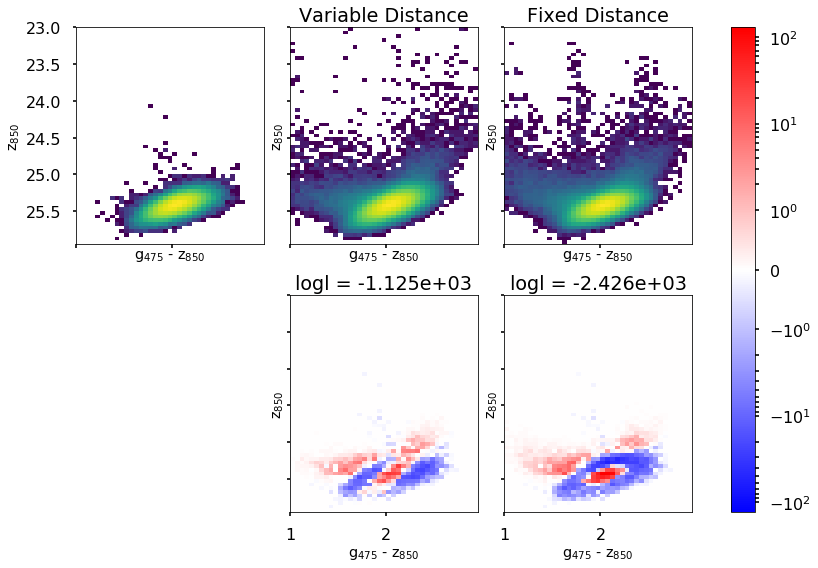

In [145]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8), sharex=True, sharey=True)


axes[0,0].hist2d(pcmd_m49[1], pcmd_m49[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].hist2d(pcmd_model[1], pcmd_model[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].set_title('Variable Distance')
axes[0,2].hist2d(pcmd_model_better[1], pcmd_model_better[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,2].set_title('Fixed Distance')

axes[1,0].axis('off')

plt.subplot(axes[1,1])
plt.imshow(e2, extent=[bins[0][0], bins[0][-1], bins[1][-1], bins[1][0]], aspect='auto', cmap='bwr', norm=mpl.colors.SymLogNorm(1., vmin=-vm, vmax=vm))
axes[1,1].set_title('logl = {:.3e}'.format(-np.abs(e2).sum()))

plt.subplot(axes[1,2])
plt.imshow(e3, extent=[bins[0][0], bins[0][-1], bins[1][-1], bins[1][0]], aspect='auto', cmap='bwr', norm=mpl.colors.SymLogNorm(1., vmin=-vm, vmax=vm))
axes[1,2].set_title('logl = {:.3e}'.format(-np.abs(e3).sum()))

for ax in axes.flatten():
    ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m49, axes=ax)
    
plt.tight_layout()
plt.colorbar(ax=axes)


In [141]:
driv.initialize_data(pcmd_m49, bins=bins[::-1])

In [142]:
driv.loglike(pcmd_model, like_mode=2), driv.loglike(pcmd_model_better, like_mode=2)

(-1340.884774225331, -2775.8989894921297)

In [143]:
driv.loglike(pcmd_model, like_mode=0), driv.loglike(pcmd_model_better, like_mode=0)

(137667.3285224354, 136348.93906000696)

In [144]:
driv.loglike(pcmd_model, like_mode=1), driv.loglike(pcmd_model_better, like_mode=1)

(-842.127022879777, -1136.4064638836194)

In [39]:
pcmd_model[0].mean()

25.55153377836312

In [399]:
base_params = np.array([0., -1.5, 4.65, 1.5, 31.3])

In [400]:
%%time
gal_m49.set_params(base_params)
pcmd_baseline = driv.simulate(gal_m49, 512, downsample=5, shot_noise=True, sky_noise=sky_m49)[0]

CPU times: user 830 ms, sys: 176 ms, total: 1.01 s
Wall time: 1.75 s


In [401]:
%%time
gal_m49.set_params(base_params + np.array([0.5, 0., 0., 0., 0.]))
pcmd_1 = driv.simulate(gal_m49, 512, downsample=5, shot_noise=True, sky_noise=sky_m49)[0]

CPU times: user 825 ms, sys: 182 ms, total: 1.01 s
Wall time: 1.48 s


In [402]:
%%time
gal_m49.set_params(base_params + np.array([-0.5, 0., 0., 0., 0.]))
pcmd_2 = driv.simulate(gal_m49, 512, downsample=5, shot_noise=True, sky_noise=sky_m49)[0]

CPU times: user 820 ms, sys: 178 ms, total: 998 ms
Wall time: 1.46 s


In [403]:
%%time
gal_m49.set_params(base_params + np.array([0., 0.5, 0., 0., 0.]))
pcmd_3 = driv.simulate(gal_m49, 512, downsample=5, shot_noise=True, sky_noise=sky_m49)[0]

CPU times: user 820 ms, sys: 198 ms, total: 1.02 s
Wall time: 1.57 s


In [404]:
%%time
gal_m49.set_params(base_params + np.array([0., -0.5, 0., 0., 0.]))
pcmd_4 = driv.simulate(gal_m49, 512, downsample=5, shot_noise=True, sky_noise=sky_m49)[0]

CPU times: user 820 ms, sys: 181 ms, total: 1 s
Wall time: 1.47 s


In [405]:
%%time
gal_m49.set_params(base_params + np.array([0., 0., 0.5, 0., 0.]))
pcmd_5 = driv.simulate(gal_m49, 512, downsample=5, shot_noise=True, sky_noise=sky_m49)[0]

CPU times: user 817 ms, sys: 178 ms, total: 995 ms
Wall time: 1.51 s


In [406]:
%%time
gal_m49.set_params(base_params + np.array([0., 0., -0.5, 0., 0.]))
pcmd_6 = driv.simulate(gal_m49, 512, downsample=5, shot_noise=True, sky_noise=sky_m49)[0]

CPU times: user 814 ms, sys: 170 ms, total: 984 ms
Wall time: 1.48 s


In [407]:
%%time
gal_m49.set_params(base_params + np.array([0., 0., 0., 1., 0.]))
pcmd_7 = driv.simulate(gal_m49, 512, downsample=5, shot_noise=True, sky_noise=sky_m49)[0]

CPU times: user 822 ms, sys: 191 ms, total: 1.01 s
Wall time: 1.48 s


In [408]:
%%time
gal_m49.set_params(base_params + np.array([0., 0., 0., -1., 0.]))
pcmd_8 = driv.simulate(gal_m49, 512, downsample=5, shot_noise=True, sky_noise=sky_m49)[0]

CPU times: user 818 ms, sys: 178 ms, total: 997 ms
Wall time: 1.47 s


In [409]:
%%time
gal_m49.set_params(base_params + np.array([0., 0., 0., 0., 1.]))
pcmd_9 = driv.simulate(gal_m49, 512, downsample=5, shot_noise=True, sky_noise=sky_m49)[0]

CPU times: user 837 ms, sys: 171 ms, total: 1.01 s
Wall time: 1.47 s


In [410]:
%%time
gal_m49.set_params(base_params + np.array([0., 0., 0., 0., -1.]))
pcmd_10 = driv.simulate(gal_m49, 512, downsample=5, shot_noise=True, sky_noise=sky_m49)[0]

CPU times: user 811 ms, sys: 185 ms, total: 997 ms
Wall time: 1.48 s


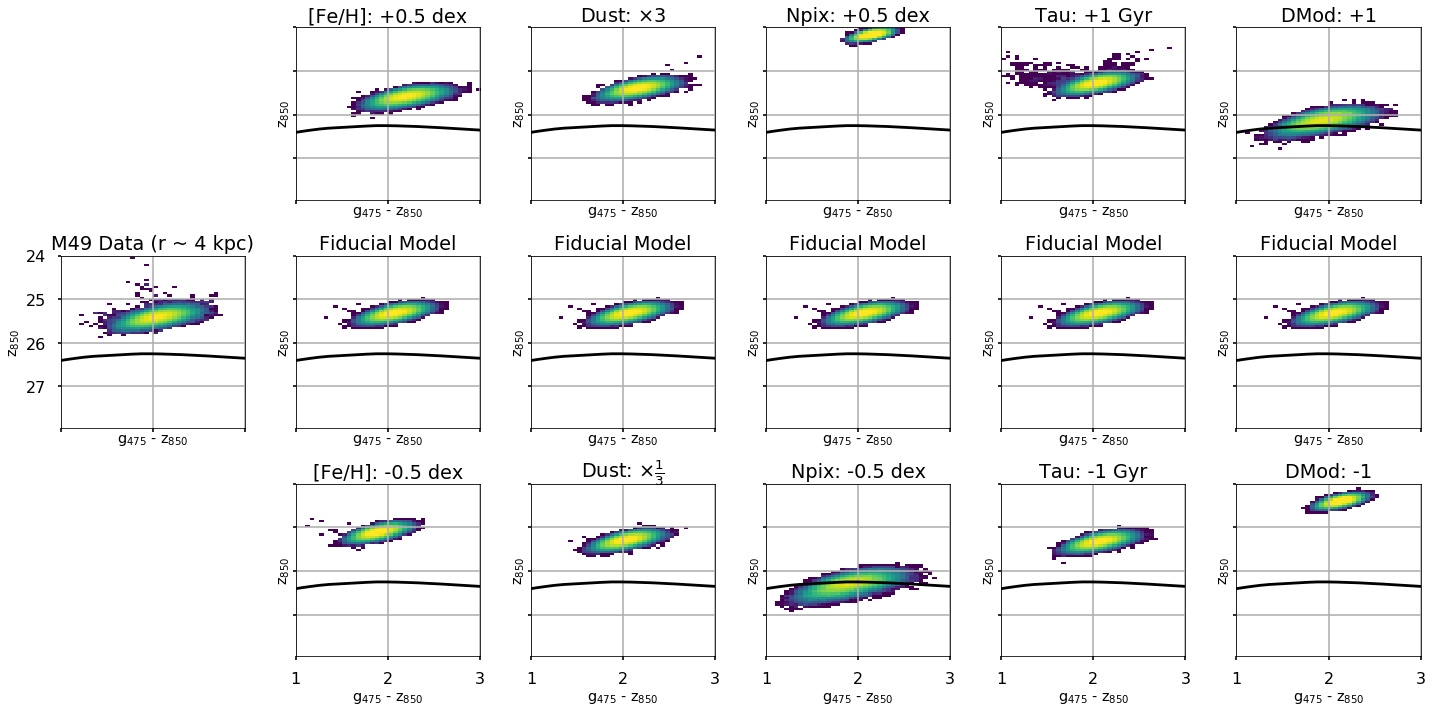

In [412]:
bins = [np.arange(1, 3.05, 0.05), np.arange(24, 28, 0.05)]
n = mpl.colors.LogNorm()

fig, axes = plt.subplots(ncols=6, nrows=3, figsize=(20, 10), sharex=True, sharey=True)
for ax in [axes[0,0], axes[2,0]]:
    ax.axis('off')
ax = axes[1,0]
ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m49, axes=ax)
ax.hist2d(pcmd_m49[1], pcmd_m49[0], bins=bins, norm=n, normed=True)
ax.set_title('M49 Data (r ~ 4 kpc)')

pcmd = pcmd_baseline
for ax in axes[1,1:]:
    ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n, normed=True)
    ax.set_title('Fiducial Model')

# vary [Fe/H]
ax = axes[0, 1]
pcmd = pcmd_1
ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n, normed=True)
ax.set_title('[Fe/H]: +0.5 dex')

ax = axes[2, 1]
pcmd = pcmd_2
ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n, normed=True)
ax.set_title('[Fe/H]: -0.5 dex')

# vary Dust
ax = axes[0, 2]
pcmd = pcmd_3
ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n, normed=True)
ax.set_title(r'Dust: $\times3$')

ax = axes[2, 2]
pcmd = pcmd_4
ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n, normed=True)
ax.set_title(r'Dust: $\times\frac{1}{3}$')

# vary Npix
ax = axes[0, 3]
pcmd = pcmd_5
ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n, normed=True)
ax.set_title(r'Npix: +0.5 dex')

ax = axes[2, 3]
pcmd = pcmd_6
ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n, normed=True)
ax.set_title(r'Npix: -0.5 dex')

# vary Tau
ax = axes[0, 4]
pcmd = pcmd_7
ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n, normed=True)
ax.set_title(r'Tau: +1 Gyr')

ax = axes[2, 4]
pcmd = pcmd_8
ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n, normed=True)
ax.set_title(r'Tau: -1 Gyr')

# vary Dmod
ax = axes[0, 5]
pcmd = pcmd_9
ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n, normed=True)
ax.set_title(r'DMod: +1')

ax = axes[2, 5]
pcmd = pcmd_10
ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n, normed=True)
ax.set_title(r'DMod: -1')

for ax in axes[:,1:].flatten():
    ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m49, axes=ax)
for ax in axes.flatten():
    ax.grid(True)
plt.tight_layout()
plt.savefig('figures/m49_model_grid.pdf')

In [425]:
f[0]._exposure = 560. * 2.
f[1]._exposure = 375. * 2.

In [426]:
base_params = np.array([0., -1.5, 6., 1.5, 30.])
bins = bins = [np.arange(1, 3, 0.05), np.arange(20.5, 21, 0.05)]

In [427]:
%%time
gal_m49.set_params(base_params)
pcmd_baseline = driv.simulate(gal_m49, 2048, downsample=5, shot_noise=True, sky_noise=sky_m49)[0]

CPU times: user 7.43 s, sys: 2.49 s, total: 9.92 s
Wall time: 10.7 s


In [428]:
%%time
d_dist = 2
gal_m49.set_params(base_params + np.array([0., 0., 0.4*d_dist, 0., d_dist]))
pcmd_far = driv.simulate(gal_m49, 2048, downsample=5, shot_noise=True, sky_noise=sky_m49)[0]

CPU times: user 7.47 s, sys: 2.65 s, total: 10.1 s
Wall time: 10.6 s


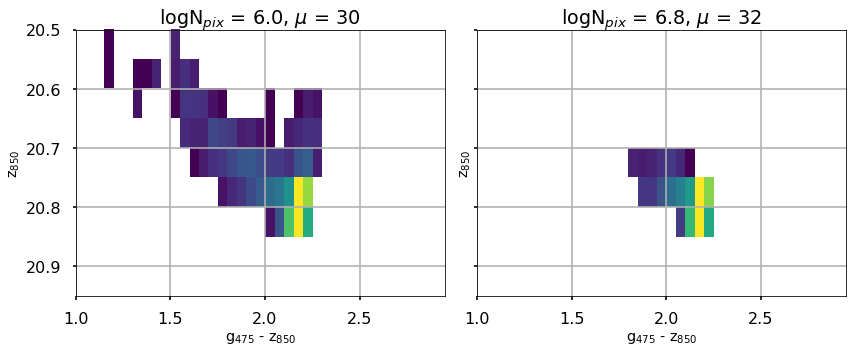

In [429]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharex=True, sharey=True)

n = mpl.colors.LogNorm()

axes[0].hist2d(pcmd_baseline[1], pcmd_baseline[0], bins=bins, norm=n, normed=True)
axes[0].set_title(r'$\log \mathrm{N}_{pix} $ = 6.0, $\mu$ = 30')
axes[1].hist2d(pcmd_far[1], pcmd_far[0], bins=bins, norm=n, normed=True)
axes[1].set_title(r'$\log \mathrm{N}_{pix} $ = 6.8, $\mu$ = 32')

for ax in axes:
    ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m49, axes=ax)
    ax.grid(True)
plt.tight_layout()
plt.savefig('figures/m49_distance_npix.pdf')

# Regions

In [9]:
region_map = fits.open('../data/m49/masks/m49_chip1_thin-annuli.fits')[1].data

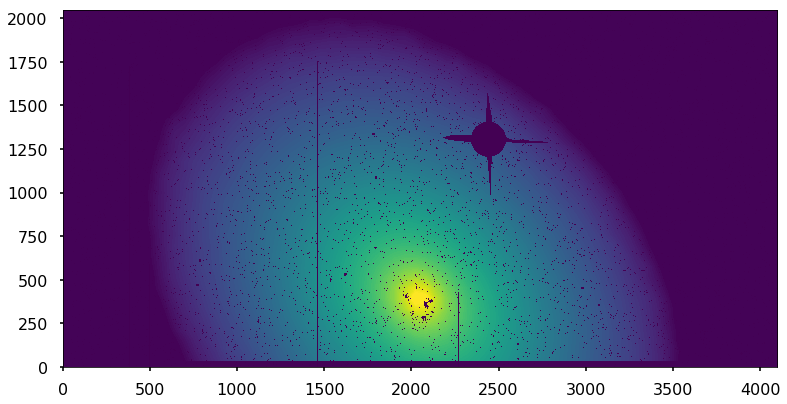

In [12]:
plt.imshow(region_map)

In [13]:
masks = {}
for i in range(1, region_map.max()+1):
    masks[i] = (region_map == i)

In [15]:
def get_stats(reg_map, mask_dict):
    x_c, y_c = np.mean(np.where(reg_map == reg_map.max()), axis=-1)
    sma_arcsecs = {}
    minr_arcsecs = {}
    npix_effs = {}
    for i in range(1, reg_map.max()+1):
        xs, ys = np.where(mask_dict[i])
        npix_effs[i] = np.sqrt(len(xs)) 
        rs = np.sqrt((xs - x_c)**2 + (ys - y_c)**2)
        sma_arcsecs[i] = np.max(rs) * 0.05
        minr_arcsecs[i] = np.min(rs) * 0.05
    d_kpc = 17000
    sma_kpc = {i: d_kpc * sma_arcsecs[i] * (np.pi / (180 * 3600.)) for i in sma_arcsecs.keys()}
    minr_kpc = {i: d_kpc * minr_arcsecs[i] * (np.pi / (180 * 3600.)) for i in minr_arcsecs.keys()}
    return npix_effs, sma_kpc, minr_kpc

In [23]:
# npixs, smas, minrs = get_stats(region_map, masks)
npixs, smas, minrs = get_stats(region_map, masks)

In [17]:
data_f475w = fits.open('../data/m49/reduced/m49_chip1_exp1_f475w_reduced.fits')['SCI'].data
data_f850lp = fits.open('../data/m49/reduced/m49_chip1_exp1_f850lp_reduced.fits')['SCI'].data

In [18]:
f475w = ppy.instrument.ACS_WFC_F475W(exposure=375.)
f850lp = ppy.instrument.ACS_WFC_F850LP(exposure=560.)

In [19]:
mags_f475w = f475w.counts_to_mag(data_f475w)
mags_f850lp = f850lp.counts_to_mag(data_f850lp)

/Users/bcook/.local/lib/python3.6/site-packages/pcmdpy/gpu_utils.py:209: RuntimeWarning: invalid value encountered in log10
  return np.log10(array_in)


In [20]:
iso_model = ppy.isochrones.Isochrone_Model([f850lp, f475w])

In [21]:
def get_pcmd(mask):
    mag = mags_f850lp[mask].flatten()
    col = (mags_f475w - mags_f850lp)[mask].flatten()
    to_use = (~np.isnan(mag))&(~np.isnan(col))
    return np.array([mag[to_use], col[to_use]])

9it [00:00, 21.40it/s]


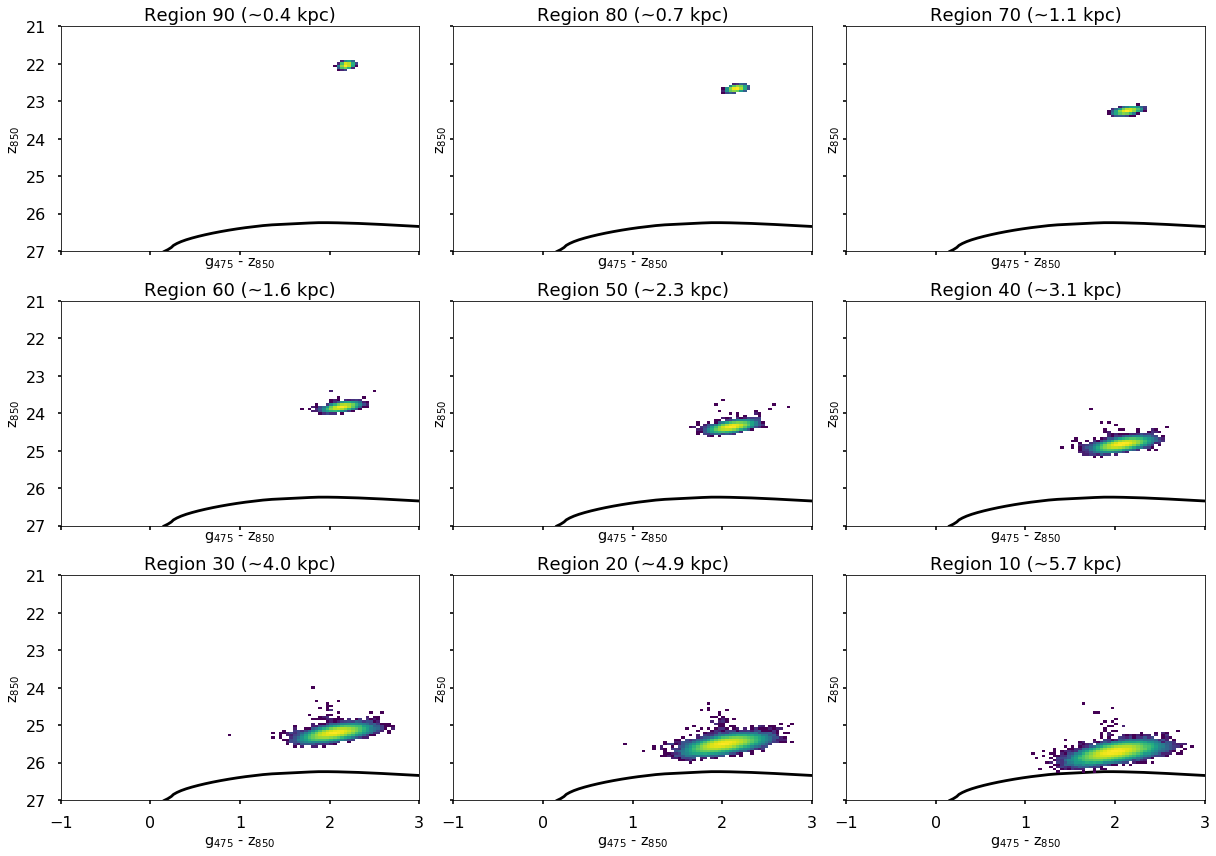

In [36]:
fig, axes = plt.subplots(figsize=(17, 12), ncols=3, nrows=3, sharex=True, sharey=True)
axes = axes.flatten()
bins = [np.linspace(-1, 3, 100), np.linspace(21, 27, 100)]
for i, r in tqdm(enumerate([90, 80, 70, 60, 50, 40, 30, 20, 10])):
    ax = axes[i]
    pcmd = get_pcmd(masks[r])
    ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=mpl.colors.LogNorm())
    ppy.plotting.plot_isochrone(iso_model, dmod=31.29, zorder=-1, axes=ax)
    ax.set_title('Region {:d} (~{:.1f} kpc)'.format(r, 0.5*(minrs[r]+smas[r])), fontsize=18)
plt.tight_layout()
plt.savefig('../../talks/TAC_Meeting_100318/m49_regions.pdf')